In [33]:
import pandas as pd
import requests
from io import StringIO
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [2]:
def get_csv_df(csv_name):
    url = f"https://storage.googleapis.com/nba_award_predictor/nba_data/{csv_name}"

    r = requests.get(url)
    r.raise_for_status()

    csv_text = r.content.decode('utf-8')
    df = pd.read_csv(StringIO(csv_text))
    return df

# Data Extraction & EDA

In [4]:
total = get_csv_df("features-overall-weekly.csv")

In [25]:
"""
full_name, player_id: not features
pow_player_id, player_of_the_week, won_player_of_week: target labels (y data)
all_star_this_season, mvp_this_season, all_nba_first_team_this_season, all_nba_second_team_this_season, all_nba_third_team_this_season: "future data", not determined until end of the season
week_start, pow_conference: redundant, we have season, week, conference
is_win_vs_over_500, opponent_has_all_nba: these were encoders for game entries, our rows are week entries

ask about breakout_score, z_... vs. team_... (is z=z-score and is team features also normalized?)
"""
X = total.drop(columns=['full_name', 'player_id', 'pow_player_id', 'player_of_the_week', 'won_player_of_the_week', 'all_star_this_season', 'mvp_this_season',
 'all_nba_first_team_this_season', 'all_nba_second_team_this_season', 'all_nba_third_team_this_season', 'week_start', 'pow_conference',
 'is_win_vs_over_500', 'opponent_has_all_nba'])

In [26]:
# Target/y label, 1 if player is winner, 0 otherwise
y = total['won_player_of_the_week']

In [27]:
# Unlike tree modeling, we do need to hot encode our categorical data: team and conference
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233734 entries, 0 to 233733
Data columns (total 56 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   team                              233734 non-null  object 
 1   season                            233734 non-null  int64  
 2   week                              233734 non-null  int64  
 3   conference                        233734 non-null  object 
 4   games_played_this_week            233734 non-null  int64  
 5   numMinutes                        233734 non-null  float64
 6   points                            233734 non-null  float64
 7   assists                           233734 non-null  float64
 8   blocks                            233734 non-null  float64
 9   steals                            233734 non-null  float64
 10  reboundsTotal                     233734 non-null  float64
 11  reboundsDefensive                 233734 non-null  f

By one hot encoding our team column, we are going to get 30+ extra columns, one for each of the teams. This will most likely inflate our principal component analysis. However, from our light gbm model, we did see that the team categorical feature was a top 3 feature when predicting a winner. Thus, we cannot drop the team column despite our model being at the player-performance level.

In [28]:
X = pd.get_dummies(X, columns=['team', 'conference'], drop_first=False).astype(int)

In [29]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233734 entries, 0 to 233733
Data columns (total 89 columns):
 #   Column                            Non-Null Count   Dtype
---  ------                            --------------   -----
 0   season                            233734 non-null  int64
 1   week                              233734 non-null  int64
 2   games_played_this_week            233734 non-null  int64
 3   numMinutes                        233734 non-null  int64
 4   points                            233734 non-null  int64
 5   assists                           233734 non-null  int64
 6   blocks                            233734 non-null  int64
 7   steals                            233734 non-null  int64
 8   reboundsTotal                     233734 non-null  int64
 9   reboundsDefensive                 233734 non-null  int64
 10  reboundsOffensive                 233734 non-null  int64
 11  fieldGoalsAttempted               233734 non-null  int64
 12  fieldGoalsMade  

In [30]:
X.head()

,season,week,games_played_this_week,numMinutes,points,assists,blocks,steals,reboundsTotal,reboundsDefensive,reboundsOffensive,fieldGoalsAttempted,fieldGoalsMade,threePointersAttempted,threePointersMade,freeThrowsAttempted,freeThrowsMade,turnovers,foulsPersonal,plusMinusPoints,wins_this_week,wins_vs_team_with_all_nba_player,avg_opp_score,avg_opp_winrate_prior,avg_opp_wins_prior,avg_opp_losses_prior,away_games_prior,away_losses_prior,away_win_streak_prior,away_wins_prior,home_games_prior,home_losses_prior,home_win_streak_prior,home_wins_prior,losses_prior,wins_vs_over_500_prior,team_pts,team_ast,team_blk,team_stl,...,plusMinusPoints_std_season,z_pts,z_ast,z_pm,breakout_score,team_76ers,team_Bobcats,team_Bucks,team_Bullets,team_Bulls,team_Cavaliers,team_Celtics,team_Clippers,team_Grizzlies,team_Hawks,team_Heat,team_Hornets,team_Jazz,team_Kings,team_Knicks,team_Lakers,team_Magic,team_Mavericks,team_Nets,team_Nuggets,team_Pacers,team_Pelicans,team_Pistons,team_Raptors,team_Rockets,team_Spurs,team_Suns,team_SuperSonics,team_Thunder,team_Timberwolves,team_Trail Blazers,team_Warriors,team_Wizards,conference_East,conference_West
0,1983,46,3,45,14,11,1,1,5,5,0,22,6,3,2,0,0,4,6,0,3,3,107,0,5,4,5,2,0,3,5,0,5,5,2,4,370,121,16,27,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,1983,47,4,39,24,7,0,1,5,3,2,20,10,5,1,4,3,3,4,0,2,1,114,0,6,6,7,3,1,4,7,1,1,6,4,6,474,120,28,30,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,1983,48,3,51,22,5,0,3,3,2,1,23,8,2,0,6,6,1,6,0,2,1,112,0,8,8,8,3,1,5,9,2,2,7,5,6,349,96,14,27,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,1983,50,3,50,11,13,1,0,2,2,0,11,5,0,0,2,1,6,6,0,2,2,112,0,11,13,9,4,0,5,13,3,1,10,7,6,348,81,14,29,...,0,-2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,1983,52,2,28,19,1,0,1,2,1,1,15,8,1,0,3,3,4,5,0,1,1,116,0,13,17,12,6,0,6,16,3,1,13,9,7,223,62,21,13,...,0,0,-2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


Let's now visualize the distribution of some of our top features from our light gbm model. Even though these features might not be statisically significant for our future regression models, since there are so many features, lets choose to examine them to get some idea of our data scale.

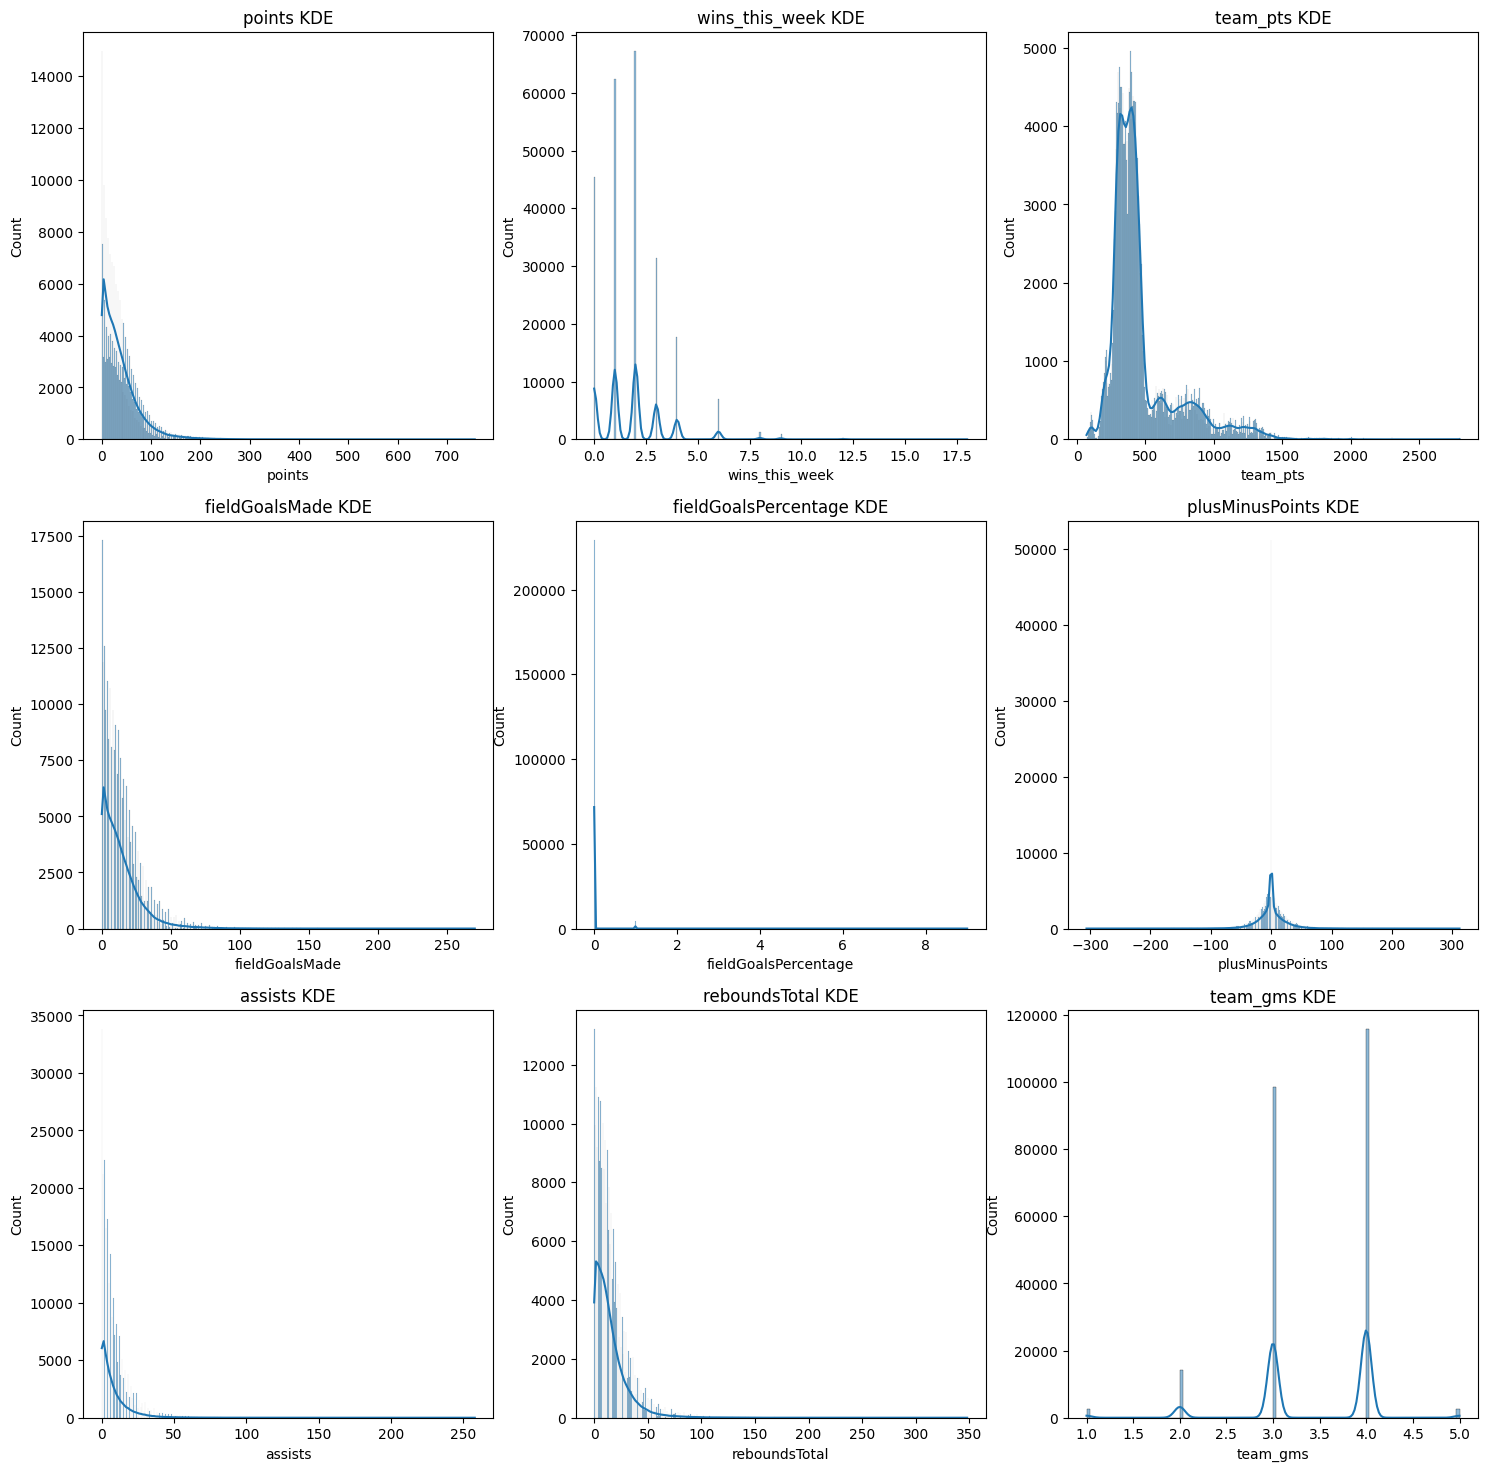

In [31]:
# Not including team feature as we 1 hot encoded it
top_features = ['points', 'wins_this_week', 'team_pts', 'fieldGoalsMade', 'fieldGoalsPercentage', 'plusMinusPoints', 'assists', 'reboundsTotal', 'team_gms']
plt.figure(figsize=(18, 18))
for i, feat in enumerate(top_features):
    plt.subplot(3, 3, i+1)
    sns.histplot(X[feat], kde=True)
    plt.title(f"{feat} KDE")
    plt.tight_layout


As we can see, our scale varies with our selected features, and it can be assumed to be the same case with the rest of the features in our data. Since PCA moves in the direction of maximum variance, a feature with a greater max value will heavily skew the analysis when compared to other features with a lower range. In other words, PCA will believe that features with greater max values are much more important when scaling the number of componenets. As such, we will scale our features using Standard Scaler as it will allow our feature distributions to be normal i.e. each feature has equal weight.

In [32]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Principal Component Analysis

In [34]:
pca = PCA(n_components=50)
pca.fit(X_scaled)

,n_components,50
,copy,True
,whiten,False
,svd_solver,'auto'
,tol,0.0
,iterated_power,'auto'
,n_oversamples,10
,power_iteration_normalizer,'auto'
,random_state,None


In [42]:
cum_var = np.cumsum(pca.explained_variance_ratio_)
opt_components = 0
for i, val in enumerate(cum_var):
    if val > 0.8:
        opt_components = i - 1
        break

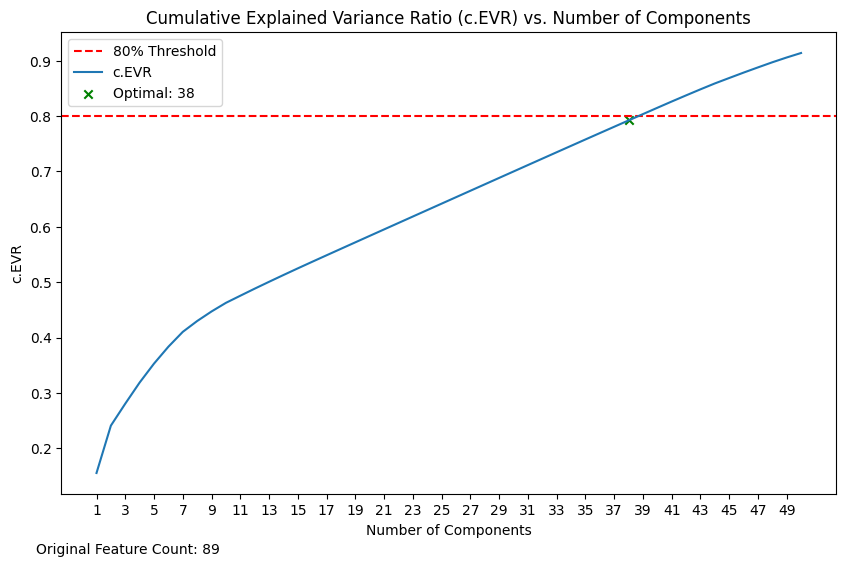

In [49]:
fig = plt.figure(figsize=(10, 6))
x = np.arange(1, len(cum_var) + 1)
x_tick = np.arange(1, len(cum_var) + 1, 2)
plt.axhline(y=0.8, color='red', linestyle='--', label='80% Threshold')
plt.plot(x, cum_var, label="c.EVR")
plt.scatter([opt_components + 1], [cum_var[opt_components]], label=f"Optimal: {opt_components + 1}", marker="x", color="green")
plt.title("Cumulative Explained Variance Ratio (c.EVR) vs. Number of Components")
plt.figtext(0.1, 0.01, f"Original Feature Count: {len(X.columns)}", fontsize=10, color="black")
plt.xticks(x_tick)
plt.legend()
plt.ylabel("c.EVR")
plt.xlabel("Number of Components");

We will be using an 80% explained variance, we have reduced our feature count of 89 to 38 components that explain 80% of the variance of our features. Given this optimal number of components, lets run our final PCA.

In [51]:
final_pca = PCA(n_components=38)
X_pca = final_pca.fit_transform(X_scaled)
comp = [f"Component_{i}" for i in range(1, 39)]
vars = final_pca.explained_variance_
pca_df = pd.DataFrame([vars], columns=comp)
pca_df

,Component_1,Component_2,Component_3,Component_4,Component_5,Component_6,Component_7,Component_8,Component_9,Component_10,Component_11,Component_12,Component_13,Component_14,Component_15,Component_16,Component_17,Component_18,Component_19,Component_20,Component_21,Component_22,Component_23,Component_24,Component_25,Component_26,Component_27,Component_28,Component_29,Component_30,Component_31,Component_32,Component_33,Component_34,Component_35,Component_36,Component_37,Component_38
0,13.823291,7.618931,3.529117,3.397241,3.046483,2.714331,2.385731,1.742957,1.537393,1.38519,1.144066,1.135332,1.104933,1.088925,1.072096,1.055856,1.046179,1.042562,1.040184,1.038867,1.036782,1.036592,1.035978,1.035516,1.035082,1.034694,1.034241,1.033893,1.033529,1.032737,1.032345,1.030663,1.030061,1.027915,1.027599,1.021794,1.019628,1.018675
